In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

ITERATIONS = [10 ** k for k in range(1, 8)]
MIN_TAU = 0
MAX_TAU = 1.5
TAU_COUNT = 300

In [2]:
FILE = 6

In [3]:
def read(f, M):
    n = int(f.readline())
    y = np.zeros(n)
    X = np.zeros((n, M))
    for i in range(n):
        tmp = list(map(int, f.readline().split()))
        y[i] = tmp[-1]
        for j in range(M):
            X[i][j] = tmp[j]
    return n, MinMaxScaler().fit_transform(X), y


with open(f"{FILE}.txt", "r") as dataFile:
    M = int(dataFile.readline())

    train_n, train_X, train_y = read(dataFile, M)
    test_n, test_X, test_y = read(dataFile, M)


In [4]:
def lsm(tau):
    if tau == 0:
        return np.linalg.pinv(train_X) @ train_y
    return np.linalg.inv(train_X.T @ train_X + tau * np.eye(M)) @ train_X.T @ train_y


def sgd(tau, iterations):
    weights = np.random.uniform(-1 / (2 * M), 1 / (2 * M), M)
    grad = 0
    _lambda = 0.9
    K = (1 - _lambda) * 2

    for step in map(lambda x: 1 / x, range(1, iterations + 1)):
        idx = random.randint(0, train_n - 1)

        grad = _lambda * grad + K * ((weights @ train_X[idx]) - train_y[idx]) * train_X[idx] + 2 * tau * weights
        weights = weights - step * grad

    return weights


def smape(weights):
    y_pred = weights @ test_X.T
    return np.mean(np.abs(test_y - y_pred) / (np.abs(test_y) + np.abs(y_pred)))


In [5]:
def best_tau(fit):
    best = 0
    best_score = smape(fit(0))
    sc = [best_score]
    ps = [best]
    for i in tqdm(np.linspace(MIN_TAU, MAX_TAU, TAU_COUNT)):
        ws = fit(i)
        score = smape(ws)
        ps.append(i)
        sc.append(score)

        if score < best_score:
            best_score = score
            best = i
    print("got best param ", best, ", with score", best_score)

    plt.loglog(ps, sc, marker='x', linestyle='None', color='r')
    plt.ylabel('smape')
    plt.xlabel('tau')
    plt.show()
    return best

100%|██████████| 300/300 [00:05<00:00, 59.86it/s]


got best param  0.005016722408026756 , with score 0.032562345685967095


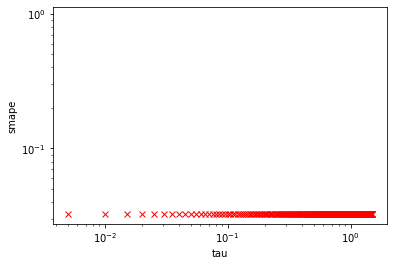

0.005016722408026756

In [6]:
best_tau(lsm)

100%|██████████| 300/300 [00:09<00:00, 33.01it/s]


got best param  0.015050167224080268 , with score 0.02260347797177694


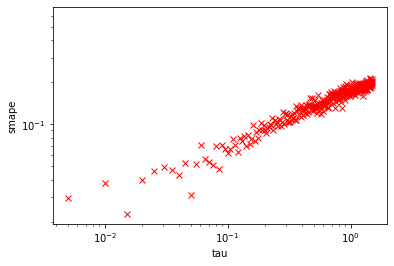

In [7]:
sgd_tau = best_tau(lambda x: sgd(x, 2000))

100%|██████████| 7/7 [01:56<00:00, 16.70s/it]


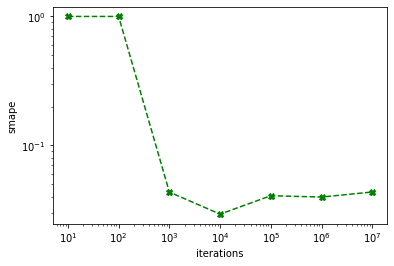

In [8]:
smaps = []
for iters in tqdm(ITERATIONS):
    smaps.append(smape(sgd(sgd_tau, iters)))

plt.loglog(ITERATIONS, smaps, color='g', marker='X', linestyle='--')
plt.ylabel('smape')
plt.xlabel('iterations')
plt.show()